## Map for woody biomass + pellet manufacturing facilities

In [34]:
import pandas as pd
import lxml
import requests
import geopandas as gpd
import zipfile
import io
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
%matplotlib inline

In [2]:
pellet_facilities = gpd.read_file('pellet_facilities.geojson')

In [25]:
se = gpd.read_file('southeast_counties.geojson')

In [4]:
pellet_facilities.head()

,Plant,Feedstock,Capacity,city,id,lat,long,state,geometry
0,Alexander Energy,Hardwood,7700,Kane,6748,41.666859,-78.814313,PA,POINT (-78.814313 41.666859)
1,American Wood Fibers-Circleville,Hardwood/softwood,45400,Circleville,6749,39.562195,-82.943366,OH,POINT (-82.943366 39.562195)
2,American Wood Fibers-Marion,Hardwood/softwood,68000,Schofield,6751,44.921923,-89.600801,WI,POINT (-89.600801 44.921923)
3,American Wood Fibers-Wisconsin,Hardwood/softwood,22700,Marion,6750,36.813236,-81.649159,VA,POINT (-81.649159 36.813236)
4,Amite BioEnergy,Softwood,525000,Kingwood,6752,39.466870,-79.647725,WV,POINT (-79.64772499999999 39.46687)


In [5]:
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.pyplot as plt
from shapely.geometry import mapping

In [13]:
from osgeo import gdal

In [15]:
filename='conus_forests.tif'
input_raster = gdal.Open(filename)
output_raster = 'conus_forests_albers.tif'
gdal.Warp(output_raster,input_raster,dstSRS='EPSG:5071')

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x00000288A69C5D80> >

In [30]:
conus_forests_path = 'conus_forests_albers.tif'#'conus_forests/w001001.adf'
# open the lidar chm
with rio.open(conus_forests_path) as src:
    conus_forests = src.read(1, masked=True)
    extent = rio.plot.plotting_extent(src)
    conus_forests_profile = src.profile
    conus_crs = src.crs

In [31]:
conus_forests.shape

(11800, 18640)

In [18]:
conus_crs

CRS({'init': 'epsg:5071'})

In [32]:
print('CHM min value:' ,conus_forests.min())
print('CHM max value:' ,conus_forests.max())

CHM min value: 0
CHM max value: 7


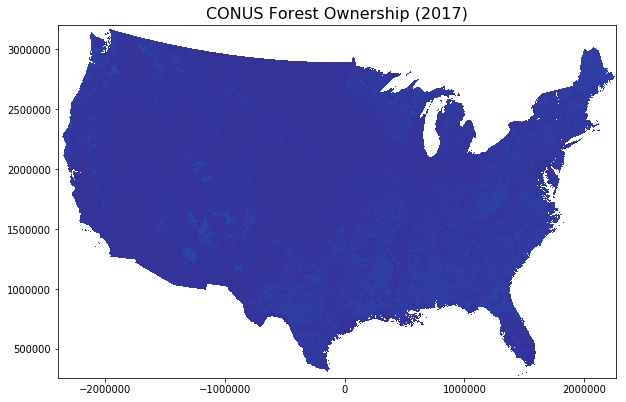

In [20]:
fig, ax = plt.subplots(figsize = (10,10))
show(band1, 
     cmap='terrain', 
     ax=ax,
      extent = extent)
ax.set_title('CONUS Forest Ownership (2017)', 
             fontsize = 16);

In [36]:
se_blob = se.dissolve(by='STATEFP')
se_blob = se_blob.to_crs({'init':'EPSG:5071'})
pellet_facilities = pellet_facilities.to_crs({'init':'EPSG:5071'})

### Metadata

https://www.fs.usda.gov/rds/archive/products/RDS-2017-0007/_metadata_RDS-2017-0007.html#Entity_and_Attribute_Information

OWNERSHIP_TYPE
````
0 = Non-Forest.
1 = Federal (Public): Owned by the federal government. FIA Codes 11-13, 21-25.
2 = State (Public): Owned by a state government. FIA Code 31.
3 = Local (Public): Owned by a local government. FIA Code 32.
4 = Family (Private): Owned by families, individuals, trusts, estates, family partnerships, and other unincorporated groups of individuals that own forest land. FIA Code 45.
5 = Corporate (Private): Owned by corporations. FIA Code 41.
6 = Other Private (Private): Owned by conservation and natural resource organizations, unincorporated partnerships and associations. FIA Codes 42-43.
7 = Tribal: Owned by Native American tribes. FIA Code 44.
````

In [42]:
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors

In [142]:
cmap = ListedColormap(["white", np.array([230,245,208])/255, "white"])
norm = colors.BoundaryNorm([0, 4, 6, 7], 4)

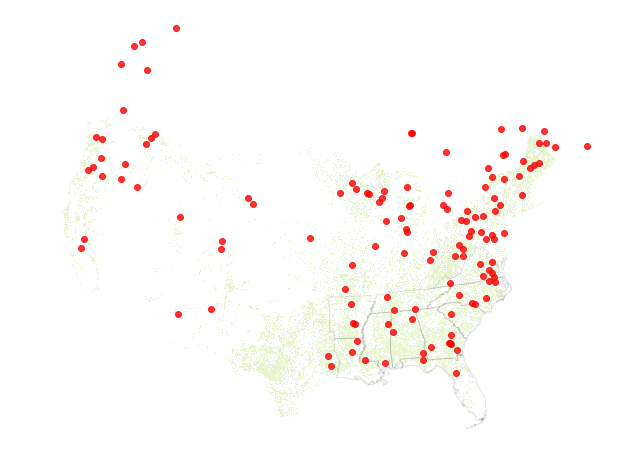

In [143]:
fig, ax = plt.subplots(figsize = (10,10))
se_blob.plot(ax=ax, alpha=0.1, color='white', edgecolor='black')
ax.imshow(ma.masked_outside(conus_forests, 4,6), 
          cmap=cmap, 
          norm=norm,
          extent=extent)
pellet_facilities.plot(ax=ax, alpha=0.8, color='r')
ax.set_axis_off();

In [54]:
from rasterio.mask import mask
from shapely.geometry import mapping
from shapely.ops import unary_union

In [76]:
se

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,1,005,00161528,0500000US01005,01005,Barbour,06,2147483647,50538698,"POLYGON ((-85.74803199999999 31.619181, -85.74..."
1,1,023,00161537,0500000US01023,01023,Choctaw,06,2147483647,19144469,"POLYGON ((-88.47322699999999 31.893856, -88.46..."
2,1,035,00161543,0500000US01035,01035,Conecuh,06,2147483647,6643480,"POLYGON ((-87.427204 31.26436, -87.425511 31.2..."
3,1,051,00161551,0500000US01051,01051,Elmore,06,1601762124,99965171,"POLYGON ((-86.413335 32.750591, -86.371151 32...."
4,1,065,00161558,0500000US01065,01065,Hale,06,1667907107,32423356,"POLYGON ((-87.870464 32.762442, -87.868184 32...."
5,1,109,00161581,0500000US01109,01109,Pike,06,1740647521,2336975,"POLYGON ((-86.19940800000001 31.807861, -86.19..."
6,1,113,00161583,0500000US01113,01113,Russell,06,1660557977,15661281,"POLYGON ((-85.434721 32.317683, -85.433745 32...."
7,1,117,00161584,0500000US01117,01117,Shelby,06,2034107820,62542790,"POLYGON ((-87.02684600000001 33.246459, -86.98..."
8,5,011,00063757,0500000US05011,05011,Bradley,06,1681514463,9532926,"POLYGON ((-92.38161599999999 33.340721, -92.38..."
9,5,015,00066975,0500000US05015,05015,Carroll,06,1631597803,22434173,"POLYGON ((-93.88986800000001 36.379174, -93.88..."


In [58]:
se_total_area = unary_union(se_blob['geometry'])
extent_se_area = mapping(se_total_area)
extent_se_area

{'type': 'MultiPolygon',
 'coordinates': [(((1337446.810757198, 269899.7775166378),
    (1337660.8368216325, 270215.3176314704),
    (1337885.008831124, 270438.809223733),
    (1338046.6013023444, 270555.4300536682),
    (1338134.9245629373, 270593.0462915218),
    (1338087.1347081603, 270425.0987688105),
    (1337984.4993018, 270260.47903168265),
    (1337797.3548010874, 270017.17718925694),
    (1337643.3201178662, 269805.50101901195),
    (1337543.6217395333, 269701.10312616),
    (1337303.031917732, 269573.5585624533),
    (1337446.810757198, 269899.7775166378)),),
  (((1342459.76826613, 270421.42368008546),
    (1342650.9905929898, 270594.44043155963),
    (1342897.86178261, 270575.7933888592),
    (1343231.983046141, 270490.71563695563),
    (1343674.9105361968, 270549.23550165206),
    (1343764.7789172104, 270210.81847986503),
    (1343722.2392607268, 270065.3059633158),
    (1343651.4692088142, 270088.45577132876),
    (1343598.5127113685, 270283.6940160385),
    (1343198.18179

In [61]:
with rio.open("conus_forests_albers.tif") as conus_forests_ds:
    conus_se, conus_se_affine = mask(conus_forests_ds,
                                     [extent_se_area],
                                     crop=True)

In [64]:
conus_se_extent = rio.plot.plotting_extent(conus_se[0], conus_se_affine)

In [74]:
pellet_facilities_se = pellet_facilities[pellet_facilities.state.isin(['AR','LA','VA','TN','NC','SC','GA','FL','AL','MS'])]

In [85]:
pellet_facilities_se.head()

,Plant,Feedstock,Capacity,city,id,lat,long,state,geometry
3,American Wood Fibers-Wisconsin,Hardwood/softwood,22700,Marion,6750,36.813236,-81.649159,VA,POINT (1263523.304441338 1625413.571843444)
21,Energex America Inc.,Hardwood,114000,Olla,6768,31.879213,-92.279353,LA,POINT (350336.0948205238 985184.034494934)
22,Enginuity Worldwide,Ag,5400,Gloster,6769,31.183380,-91.035410,MS,POINT (471417.356922258 913179.7928932894)
23,Enviva Pellets Ahoskie,Hardwood/softwood,370000,Atlanta,6767,32.796224,-91.753882,GA,POINT (395217.3700563552 1089386.4308998)
24,Enviva Pellets Amory,Hardwood/softwood,120000,Nahunta,6996,31.209652,-81.955452,GA,POINT (1328938.3992343 1002164.386414631)


In [89]:
pellet_facilities_se.Capacity.max()

'9100'

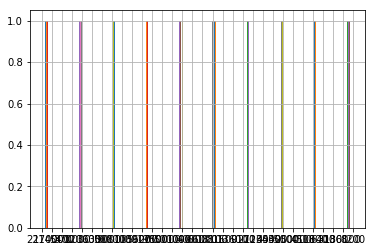

In [90]:
pellet_facilities_se.Capacity.hist()

In [158]:
rgb_pellet = [[128,128,128],[158,188,218],[140,150,198],[136,86,167],[129,15,124]]
rgb_pellet_a = np.array(rgb_pellet)/255.

cmap_pellet = ListedColormap(rgb_pellet_a,'')
val = np.array([0, 0.5e5, 1e5, 3e5, 5e5, 7.5e5]) / (25 ** 2)
norm_pellet = colors.BoundaryNorm(np.array(val), 5)

In [135]:
val

array([  0.,  20.,  40., 120., 200., 300.])

In [106]:
cmap_pellet

array([[0.94117647, 0.97647059, 0.90980392],
       [0.72941176, 0.89411765, 0.7372549 ],
       [0.48235294, 0.8       , 0.76862745],
       [0.2627451 , 0.63529412, 0.79215686],
       [0.03137255, 0.40784314, 0.6745098 ]])

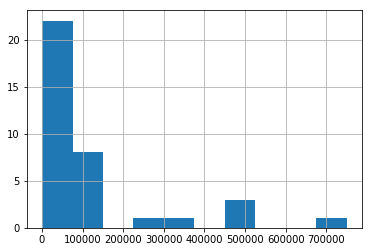

In [122]:
pellet_facilities_se.Capacity.astype(float).hist()

In [117]:
pellet_facilities_se.Capacity.astype(float) / (50 ** 2)

3        9.08
21      45.60
22       2.16
23     148.00
24      48.00
31      14.52
32      14.52
33       0.20
34      36.00
35      32.00
36      43.56
37      22.48
38       7.60
39     300.00
40     200.00
41       4.36
42      16.00
46      26.40
48     200.00
51     200.00
52       7.24
53      32.64
57       5.44
58       3.64
59      10.88
69      14.52
71      45.36
72      18.16
79      14.00
96     100.00
102      1.80
110      4.72
111      2.56
115     12.72
116     54.44
122      3.28
Name: Capacity, dtype: float64

In [132]:
np.array(pellet_facilities_se.Capacity.astype(float) / (50 ** 2))

array([9.080e+00, 4.560e+01, 2.160e+00, 1.480e+02, 4.800e+01, 1.452e+01,
       1.452e+01, 2.000e-01, 3.600e+01, 3.200e+01, 4.356e+01, 2.248e+01,
       7.600e+00, 3.000e+02, 2.000e+02, 4.360e+00, 1.600e+01, 2.640e+01,
       2.000e+02, 2.000e+02, 7.240e+00, 3.264e+01, 5.440e+00, 3.640e+00,
       1.088e+01, 1.452e+01, 4.536e+01, 1.816e+01, 1.400e+01, 1.000e+02,
       1.800e+00, 4.720e+00, 2.560e+00, 1.272e+01, 5.444e+01, 3.280e+00])

In [152]:
from matplotlib.patches import Patch

In [160]:
import matplotlib as mpl
mpl.rcParams['svg.fonttype'] = 'none'

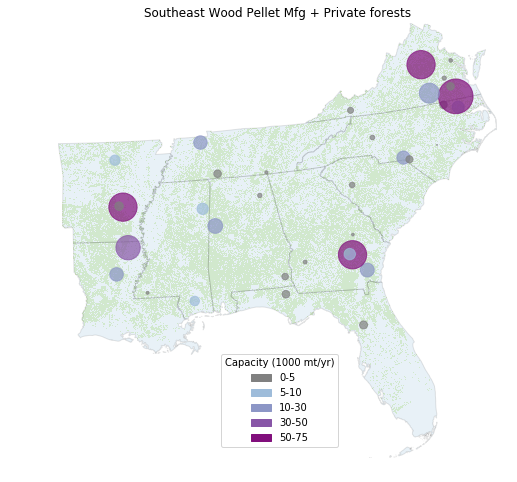

In [161]:
fig2, ax2 = plt.subplots(figsize=(10, 8))

se_blob.plot(ax=ax2, alpha=0.1, color=None, edgecolor='black')
#se.plot(ax=ax2, alpha=0.1, color=None, edgecolor='black')
ax2.imshow(ma.masked_outside(conus_se[0], 4,6), 
          cmap=cmap, 
          norm=norm,
          extent=conus_se_extent)
ax2.scatter(x=pellet_facilities_se.geometry.x,y=pellet_facilities_se.geometry.y,
            s=pellet_facilities_se.Capacity.astype(float) / (25 ** 2), 
            c=np.array(pellet_facilities_se.Capacity.astype(float) / (25 ** 2)),
            alpha = 0.7,
            norm=norm_pellet, 
            cmap=cmap_pellet)
#pellet_facilities_se.plot(ax=ax2, alpha=0.8, cmap='Set2')
ax2.set_title("Southeast Wood Pellet Mfg + Private forests")

# Add a legend for labels
legend_labels = {0: "0-5",
                 1: "5-10",
                 2: "10-30",
                 3: "30-50",
                 4: "50-75"}

patches = [Patch(color=rgb_pellet_a[color], label=label) for color, label in legend_labels.items()]
ax2.legend(title='Capacity (1000 mt/yr)',
          handles=patches, 
          bbox_to_anchor=(0.65,0.25), 
          facecolor="white")
ax2.set_axis_off()
plt.savefig('pellets_forests_2.svg', pad_inches=0.1, dpi=600)

In [150]:
 rgb_pellet_a[4]

array([0.50588235, 0.05882353, 0.48627451])

In [69]:
with rio.open("conus_forests_albers.tif") as conus_forests_ds:
    conus_se_meta = conus_forests_ds.meta

conus_se_meta.update({'transform': conus_se_affine,
                       'height': conus_se.shape[1],
                       'width': conus_se.shape[2],
                       'nodata': 255.0})
conus_se_meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 255.0,
 'width': 6844,
 'height': 6789,
 'count': 1,
 'crs': CRS({'init': 'epsg:5071'}),
 'transform': Affine(250.00000000000003, 0.0, 122533.00000000047,
        0.0, -250.00000000000003, 1966661.350289733)}

In [71]:
path_out = "conus_se.tif"
with rio.open(path_out, 'w', **conus_se_meta) as ff:
    ff.write(conus_se[0], 1)